In [1]:
import sys
sys.path.append('../')
import shap
import torch
import cv2
from torch.utils.data import DataLoader
from Run_Experiments.mri_dataset import MRI_Dataset
from torchvision.models.efficientnet import efficientnet_v2_l
import numpy 
import torchvision
from combined_classifier_shap import CombinedClassifierL 
import matplotlib.pyplot as plt
from custom_image_shap import image as image_plot



In [2]:
#train_dataset = MRI_Dataset('/Users/olath/Documents/GitHub/Master-thesis/Datasets/train-CN-sMCI-pMCI-AD','/Users/olath/Documents/ADNI_SLICED_RESCALED/', transform=transform, slice= 12, orientation= 'AXIAL') 
val_dataset = MRI_Dataset('/Users/olath/Documents/GitHub/Master-thesis/Datasets/train-CN-sMCI-pMCI-AD','/Users/olath/Documents/ADNI_SLICED_RESCALED/', slice= 12, orientation = 'AXIAL')

#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader  = DataLoader(val_dataset, batch_size=16, shuffle=True)

#X, y = validation_loader()

In [3]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
#device = 'cpu'

model = efficientnet_v2_l(num_classes = 4)
model.load_state_dict(torch.load('/Users/olath/Downloads/model_12AXIAL_202503010344_best.pth', weights_only=True, map_location=torch.device('mps')))
#sagittal = efficientnet_v2_l(num_classes = 4)
#sagittal.load_state_dict(torch.load('/fp/homes01/u01/ec-olathor/Documents/thesis/model_72SAGITTAL_202502281601_best.pth', weights_only=True, map_location=torch.device('cuda')))
#coronal = efficientnet_v2_l(num_classes = 4)
#coronal.load_state_dict(torch.load('/fp/homes01/u01/ec-olathor/Documents/thesis/model_44CORONAL_202502280117_best.pth', weights_only=True, map_location=torch.device('cuda')))
#axial.eval()
#sagittal.eval()
#coronal.eval()  

#model = CombinedClassifierL(4, axial, sagittal, coronal, dropout= 0.8)
#model.load_state_dict(torch.load('/Users/olath/Downloads/model_4class_202503031601_best.pth', weights_only=True, map_location=torch.device('mps')))
model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [4]:
def f(x):
    x = torch.from_numpy(x)
    #x = torch.clone(x)
    x = torch.permute(x,(0, 3, 1, 2))
    return model(x.to(device))


In [19]:
X, y = next(iter(validation_loader))
#X, y = X.to(device), y.to(device)

y_num = y[2:3].numpy()

print(y_num)


labels = {0: 'True class: CN', 1:'True class: sMCI', 2: 'True class: pMCI', 3:'True class: AD'}
true_labels = list()

for  label in y_num:    

    true_labels.append(labels[label])

print(true_labels)

masker = shap.maskers.Image("blur(128,128)", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker)

#print(X[1:3#].shape)


# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[2:3], max_evals=50000, batch_size=16, outputs=shap.Explanation.argsort.flip[:4])

[1]
['True class: sMCI']


  0%|          | 0/49998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:28, 268.56s/it]              


In [20]:
# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * numpy.array(mean) / numpy.array(std)).tolist(),
        std=(1 / numpy.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [21]:
shap_values_data = inv_transform(shap_values.data).cpu().numpy()
shap_values_values = [val for val in numpy.moveaxis(shap_values.values, -1, 0)]


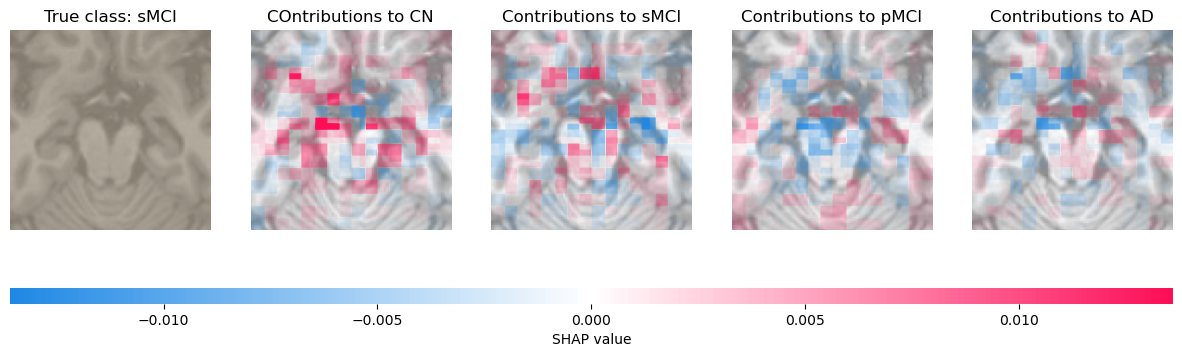

In [22]:
image_plot(
    shap_values=shap_values_values,
    pixel_values=shap_values_data,
    labels = ['COntributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'],
    true_labels = true_labels,
    show = False
)

plt.savefig("test.png", dpi = 1200) 

In [16]:
values = shap_values.values
data = shap_values.data

In [17]:
data_num = data.numpy()
data_scaled = data_num/data_num.max()
values2 = values + 2626.385322093757
values_scaled = values2/values2.max()
print(data_scaled.max())
print(values_scaled.max())

1.0
1.0


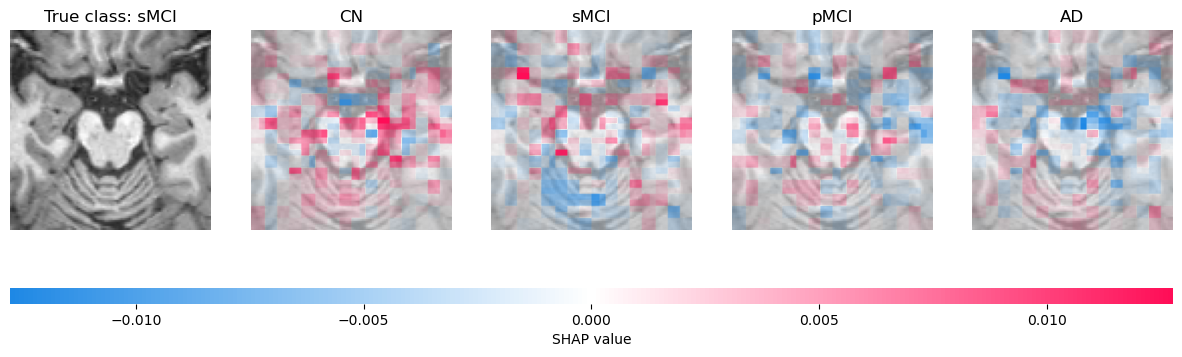

In [18]:
image_plot(
    shap_values=shap_values_values,
    pixel_values=data_scaled,
    labels = ['CN', 'sMCI', 'pMCI', 'AD'],
    true_labels = true_labels
)

In [12]:
shap_values.values
numpy.set_printoptions(threshold=sys.maxsize)
print(shap_values.values)


[[[[[ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]
    [ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]
    [ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]]

   [[ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]
    [ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]
    [ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]]

   [[ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]
    [ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]
    [ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]]

   [[ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]
    [ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]
    [ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]]

   [[ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]
    [ 3.16212837e-05  2.35503733e-04 -3.31521960e-04 -2.10324362e-04]
    [ 3.1621